# Buildig a decision tree model with Python on Bank Turnover Dataset

In [1]:
# Import necessary libraries
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
churn_df = pd.read_csv(r'C:\Users\isa.zeynalov\Desktop\Churn_Modelling.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
churn_df.duplicated().sum()

0

In [5]:
churn_df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In evaluating the performance of our churn prediction model, it's crucial to consider the inherent class imbalance in the dataset, where approximately 80% of observations correspond to non-churning customers and 20% to churners. Relying solely on accuracy as a performance metric might be misleading, as a model predicting no churn for all instances could still achieve an accuracy of around 80%. However, such an approach would fail to identify any customers who actually churned, rendering accuracy an inadequate measure.

To discern the effectiveness of our model, we must delve into the nuances of its errors. Two key types of misclassifications are false positives and false negatives. False positives occur when the model predicts a customer will churn, but they do not. Conversely, false negatives arise when the model fails to predict a customer's churn when it actually occurs.

Precision, representing the proportion of true positives among all predicted positives, may not be the most suitable metric. It discourages predicting churn unless there is a high degree of certainty, potentially leading to a higher rate of false negatives. On the other hand, recall, indicating the percentage of actual positives correctly identified by the model, may also not be ideal. It may incentivize predicting churn even when the likelihood is low, potentially resulting in a higher rate of false positives.

To determine which type of misclassification is more detrimental, we need to consider the associated costs. For this exercise, let's assume that the cost to the bank is primarily determined by the average balance of customers who churned. By calculating the average balance of these customers, we gain insights into the potential financial impact of both false positives and false negatives.

This approach allows us to estimate the monetary consequences of predicting churn when it doesn't occur (false positives) and failing to predict churn when it does (false negatives). It's important to note that the actual cost function may vary based on the specific business context and the relative importance assigned to false positives and false negatives.

In [6]:
# Calculate average balance of customers who churned
avg = churn_df[churn_df['Exited']==1]['Balance'].mean()
avg

91108.53933726068

In [7]:
# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
df = churn_df.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)

In [8]:
df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Age              10000 non-null  int64  
 3   Tenure           10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 781.4+ KB


In [10]:
# Define the y (target) variable
y = churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.drop('Exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [12]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # You may need to import SimpleImputer
    # Add any other preprocessing steps for numerical features here
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    # Add any other preprocessing steps for categorical features here
])

# Combine the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with preprocessing and the decision tree model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(random_state=0))
                            ])


In [13]:
# Define the hyperparameters to search over
param_grid = {
    'classifier__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50],
    'classifier__min_samples_leaf': [2, 5, 10, 20, 50]
}

scoring = ['f1', 'recall', 'accuracy', 'precision']

# Instantiate the GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=5, refit='f1')

# Fit the model
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_...
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Surname', 'Geography', 'Gender'], dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'classifier__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12,
                                                   15, 20, 30, 40, 50],
                         'classifier__min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring=['f1', 'recall', 'accuracy', 'precision'])

In [21]:
# Examine the best model from GridSearch
best_model = grid_search.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 20}


In [14]:
# Generate performance metrics
y_pred = grid_search.predict(X_test)
print("Accuracy:", "%.3f" % accuracy_score(y_test, y_pred))
print("Precision:", "%.3f" % precision_score(y_test, y_pred))
print("Recall:", "%.3f" % recall_score(y_test, y_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, y_pred))

Accuracy: 0.858
Precision: 0.723
Recall: 0.487
F1 Score: 0.582


In [15]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = grid_search.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

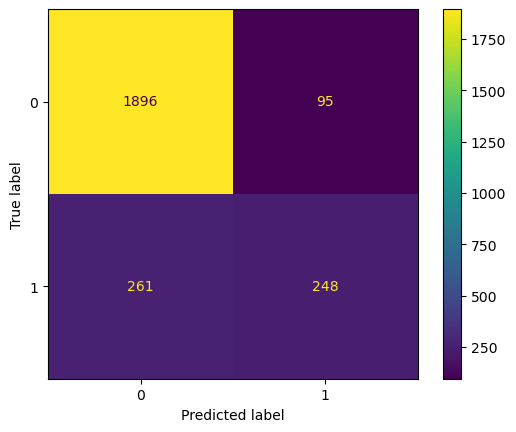

In [16]:
# Generate confusion matrix
conf_matrix_plot(grid_search, X_test, y_test)

In [17]:
print("Available scoring metrics:", grid_search.scoring)


Available scoring metrics: ['f1', 'recall', 'accuracy', 'precision']


In [18]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [19]:
make_results("Tuned Decision Tree", grid_search)

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.557335,0.486917,0.654075,0.842667
